## Importing Packages ##

In [21]:
import os
import sys
import subprocess
import tempfile
import random
from itertools import compress
import os.path as op
import numpy as np
import skimage.io as sio
import pandas as pd
import importlib
import math
from math import sqrt

import matplotlib.pyplot as plt
from os import listdir, getcwd, chdir
from os.path import isfile, join
from sklearn import linear_model
from sklearn import svm
import diff_classifier
import diff_classifier.utils as ut
import diff_classifier.msd as msd
import diff_classifier.features as ft
import diff_classifier.heatmaps as hm
import diff_classifier.aws as aws

## Defining filename and importing video - will eventually convert to a for loop to loop through list of videos ##

In [ ]:
tiffname = 'PBS_control_2.tif'

In [ ]:
os.getcwd()

In [ ]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/')
test = sio.imread('TIFS/'+tiffname)
oshape = test.shape
oshape

## Splitting original 2048x2044 video into smaller videos - takes the video imported just above and splits it into 64 256x256 smaller videos - could potentially adjust this to split into 25 or 36 vids, but for now keeping at 64 (easier to track the small vids) ##

In [ ]:
test2 = np.zeros((oshape[0], 1024, 1024), dtype=test.dtype)

test2[0:oshape[0], 0:oshape[1], :] = test

new_image = np.zeros((oshape[0], 512, 512), dtype=test.dtype)
names = []

for row in range(2):
    for col in range(2):
        new_image = test2[:, row*512:(row+1)*512, col*512:(col+1)*512]
        current = tiffname.split('.tif')[0] + '_%s_%s.tif' % (row, col)
        sio.imsave(current, new_image)
        names.append(current)

## For now, tracking is done manually using the plugin TrackMate in ImageJ. The cells located below this can be used to rename the trajectory .csv files to the proper 'Traj_... .csv' format ##

In [ ]:
os.chdir('/Users/brendanbutler/Desktop/Nance Lab/Data/diff_classifier/notebooks/development/MPT_Data/Acute 2h 10uM Traj csv')
os.getcwd()

In [ ]:
files = os.listdir()
print(files)

## Defining list of all small videos to be quantified (calculating msds and features) ##

In [37]:
from pathlib import Path

filename = "5k_XL_1_1_25C"

ires = (512, 512)
frames = 651
rows = 3
cols = 3

# Get all CSV files in a directory
directory = "/Users/nelsschimek/Downloads/damien collab csv/5kXL25C/5kXL_3_25C"  # Current directory, or use "/path/to/your/directory"
names = [f.name for f in Path(directory).glob("*.csv")]

print(names)

['5k_XL_3_25C_3_0_3.csv', '5k_XL_3_25C_3_0_2.csv', '5k_XL_3_25C_3_2_2.csv', '5k_XL_3_25C_3_0_0.csv', '5k_XL_3_25C_3_2_3.csv', '5k_XL_3_25C_1_1_0.csv', '5k_XL_3_25C_2_0_0.csv', '5k_XL_3_25C_2_2_2.csv', '5k_XL_3_25C_2_2_3.csv', '5k_XL_3_25C_2_0_1.csv', '5k_XL_3_25C_1_1_3.csv', '5k_XL_3_25C_2_0_3.csv', '5k_XL_3_25C_1_3_1.csv', '5k_XL_3_25C_2_2_1.csv', '5k_XL_3_25C_2_2_0.csv', '5k_XL_3_25C_1_3_0.csv', '5k_XL_3_25C_2_0_2.csv', '5k_XL_3_25C_1_1_2.csv', '5k_XL_3_25C_3_3_2.csv', '5k_XL_3_25C_3_3_3.csv', '5k_XL_3_25C_3_1_1.csv', '5k_XL_3_25C_3_1_3.csv', '5k_XL_3_25C_3_3_1.csv', '5k_XL_3_25C_3_3_0.csv', '5k_XL_3_25C_3_1_2.csv', '5k_XL_3_25C_1_2_1.csv', '5k_XL_3_25C_2_3_1.csv', '5k_XL_3_25C_1_0_3.csv', '5k_XL_3_25C_2_1_3.csv', '5k_XL_3_25C_2_1_2.csv', '5k_XL_3_25C_2_3_0.csv', '5k_XL_3_25C_1_2_0.csv', '5k_XL_3_25C_1_2_2.csv', '5k_XL_3_25C_2_3_2.csv', '5k_XL_3_25C_1_0_0.csv', '5k_XL_3_25C_2_1_0.csv', '5k_XL_3_25C_2_1_1.csv', '5k_XL_3_25C_1_2_3.csv']


In [18]:
names

['5k_XL_1_3_37C_3_2.csv',
 '5k_XL_1_3_37C_1_0.csv',
 '5k_XL_1_3_37C_1_1.csv',
 '5k_XL_1_3_37C_3_3.csv',
 '5k_XL_1_3_37C_3_1.csv',
 '5k_XL_1_3_37C_1_3.csv',
 '5k_XL_1_3_37C_1_2.csv',
 '5k_XL_1_3_37C_3_0.csv',
 '5k_XL_1_3_37C_0_3.csv',
 '5k_XL_1_3_37C_2_1.csv',
 '5k_XL_1_3_37C_2_0.csv',
 '5k_XL_1_3_37C_0_2.csv',
 '5k_XL_1_3_37C_0_0.csv',
 '5k_XL_1_3_37C_2_2.csv',
 '5k_XL_1_3_37C_0_1.csv',
 '5k_XL_1_1_37C_2_1.csv',
 '5k_XL_1_1_37C_0_3.csv',
 '5k_XL_1_1_37C_0_2.csv',
 '5k_XL_1_1_37C_2_0.csv',
 '5k_XL_1_1_37C_2_2.csv',
 '5k_XL_1_2_37C_3_0.csv',
 '5k_XL_1_2_37C_1_2.csv',
 '5k_XL_1_2_37C_1_3.csv',
 '5k_XL_1_2_37C_3_3.csv',
 '5k_XL_1_2_37C_1_1.csv',
 '5k_XL_1_2_37C_1_0.csv',
 '5k_XL_1_1_37C_1_0.csv',
 '5k_XL_1_1_37C_3_3.csv',
 '5k_XL_1_1_37C_1_1.csv',
 '5k_XL_1_1_37C_3_1.csv',
 '5k_XL_1_1_37C_1_2.csv',
 '5k_XL_1_2_37C_0_1.csv',
 '5k_XL_1_2_37C_2_2.csv',
 '5k_XL_1_2_37C_2_0.csv']

## Calculating MSDs and features for the videos that have been tracked. This uses the Traj .csv files and generates an msd and features .csv file for the videos being quantified. It uses the multiple small vid Traj .csv files to generate a single msd and features .csv file. Essentially, this runs the kn.assemble_msds() function ##

In [38]:
import pandas as pd
import os

# Setup
os.chdir('/Users/nelsschimek/Downloads/damien collab csv/5kXL25C/5kXL_3_25C')
msd_file = 'msd_{}.csv'.format(filename)
ft_file = 'features_{}.csv'.format(filename)

def process_csv(filepath):
    """Load and clean a single CSV file"""
    df = pd.read_csv(filepath, skiprows=[1, 2, 3])
    
    # Remove unwanted columns
    cols_to_drop = ['LABEL', 'POSITION_Z', 'POSITION_T', 'RADIUS', 'VISIBILITY']
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Rename columns
    df = df.rename(columns={
        'ID': 'Spot_ID',
        'TRACK_ID': 'Track_ID',
        'QUALITY': 'Quality',
        'FRAME': 'Frame',
        'POSITION_X': 'X',
        'POSITION_Y': 'Y',
        'MEAN_INTENSITY_CH1': 'Mean_Intensity',
        'SNR_CH1': 'SN_Ratio'
    })
    
    df = df.sort_values(['Track_ID', 'Frame']).astype('float64')
    
    # Renumber Track_IDs sequentially
    for i, partid in enumerate(df.Track_ID.unique()):
        df.loc[df.Track_ID == partid, 'Track_ID'] = i
    
    return df

# Process all CSV files
all_msds = []
max_track_id = -1

for name in names:
    try:
        # Process CSV
        df = process_csv(name)
        
        # Adjust Track_IDs to be unique across all files
        if max_track_id >= 0:
            df['Track_ID'] = df['Track_ID'] + max_track_id + 1
        
        # Calculate MSDs
        msds = msd.all_msds2(df, frames=frames)
        all_msds.append(msds)
        
        # Update max Track_ID
        if len(df) > 0:
            max_track_id = df['Track_ID'].max()
        
        print(f'Done processing: {name}')
        
    except pd.errors.EmptyDataError:
        print(f'Found empty file: {name}')
    except Exception as e:
        print(f'Error processing {name}: {e}')

# Merge all MSDs
if all_msds:
    merged = pd.concat(all_msds, ignore_index=True)
    merged.to_csv(msd_file, index=False)
    
    # # Calculate features
    merged_ft = ft.calculate_features(merged, mean_values=False)
    merged_ft.to_csv(ft_file, index=False)
    
    print(f'Saved {len(all_msds)} files to {msd_file}')
else:
    print('No data to process')

Done processing: 5k_XL_3_25C_3_0_3.csv
Done processing: 5k_XL_3_25C_3_0_2.csv
Done processing: 5k_XL_3_25C_3_2_2.csv
Done processing: 5k_XL_3_25C_3_0_0.csv
Done processing: 5k_XL_3_25C_3_2_3.csv
Done processing: 5k_XL_3_25C_1_1_0.csv
Done processing: 5k_XL_3_25C_2_0_0.csv
Done processing: 5k_XL_3_25C_2_2_2.csv
Done processing: 5k_XL_3_25C_2_2_3.csv
Done processing: 5k_XL_3_25C_2_0_1.csv
Done processing: 5k_XL_3_25C_1_1_3.csv
Done processing: 5k_XL_3_25C_2_0_3.csv
Done processing: 5k_XL_3_25C_1_3_1.csv
Done processing: 5k_XL_3_25C_2_2_1.csv
Done processing: 5k_XL_3_25C_2_2_0.csv
Done processing: 5k_XL_3_25C_1_3_0.csv
Done processing: 5k_XL_3_25C_2_0_2.csv
Done processing: 5k_XL_3_25C_1_1_2.csv
Done processing: 5k_XL_3_25C_3_3_2.csv
Done processing: 5k_XL_3_25C_3_3_3.csv
Done processing: 5k_XL_3_25C_3_1_1.csv
Done processing: 5k_XL_3_25C_3_1_3.csv
Done processing: 5k_XL_3_25C_3_3_1.csv
Done processing: 5k_XL_3_25C_3_3_0.csv
Done processing: 5k_XL_3_25C_3_1_2.csv
Done processing: 5k_XL_3_

/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:112: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(msd_alpha, xpos, ypos)
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (
/U

Optimal parameters not found. Print NaN instead.


/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in scalar divide
  aspratio = width/height
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:510: RuntimeWarning: divide by zero encountered in sc

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.


/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:717: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (dframe['MSDs'][fram1]/dframe['MSDs'][fram2]) - (
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:830: RuntimeWarning: Mean of empty slice
  datai['SN_Ratio'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:826: RuntimeWarning: Mean of empty slice
  datai['Mean_Intensity'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:830: RuntimeWarning: Mean of empty slice
  datai['SN_Ratio'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:826: RuntimeWarning: Mean of empty slice
  datai['Mean_Intensity'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_cl

Optimal parameters not found. Print NaN instead.


/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:826: RuntimeWarning: Mean of empty slice
  datai['Mean_Intensity'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:830: RuntimeWarning: Mean of empty slice
  datai['SN_Ratio'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:826: RuntimeWarning: Mean of empty slice
  datai['Mean_Intensity'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:830: RuntimeWarning: Mean of empty slice
  datai['SN_Ratio'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:826: RuntimeWarning: Mean of empty slice
  datai['Mean_Intensity'][particle] = np.nanmean(single_track[
/Users/nelsschimek/Documents/nancelab/diff_classifier/diff_classifier/features.py:

Optimal parameters not found. Print NaN instead.
Optimal parameters not found. Print NaN instead.
Saved 38 files to msd_5k_XL_1_1_25C.csv


Successfully generated trajectory plot for 5k_XL_2_37C
Successfully generated csv files for 5k_XL_2_37C


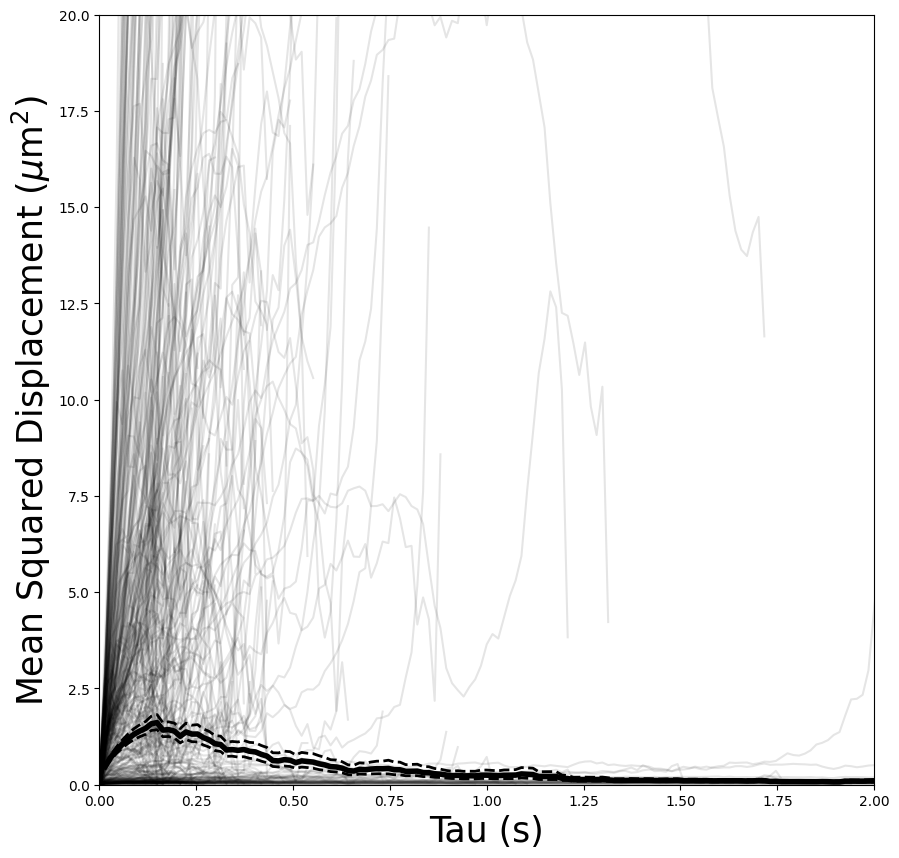

In [61]:
os.chdir('/Users/nelsschimek/Downloads/damien collab csv/5kXL37C/5k_XL_2_37C')

filename = "5k_XL_2_37C"

prefix = filename
msds = 'msd_{}.csv'.format(prefix)
#feat = 'features_{}.csv'.format(prefix)
#print(msds)
#hm.plot_trajectories(prefix, resolution=683, rows=3, cols=3, upload=False, figsize=(12, 12), bucket = 'mckenna.data')
print('Successfully generated trajectory plot for {}'.format(prefix))
geomean, geoSEM = hm.plot_individual_msds(prefix, x_range=2, y_range=20, umppx=0.1625, fps=67, upload=False, bucket='mckenna.data')
print('Successfully generated csv files for {}'.format(prefix))